In this notebook we dig a little deeper into the [Hubert transcription model](https://huggingface.co/patrickvonplaten/hubert-xlarge-ls960-ft-4-gram); in particular we try to assess the probabilities of both the phonetic model as well as the language model

### Environment setup 

In [1]:
%%writefile setup.sh
wget https://packages.microsoft.com/config/ubuntu/18.04/packages-microsoft-prod.deb
sudo dpkg -i packages-microsoft-prod.deb
sudo apt-get update
sudo apt-get install fuse
sudo apt-get install blobfuse
sudo apt install ffmpeg
sudo apt-get install libsndfile1


Writing setup.sh


In [2]:
%%capture
%%sh
bash setup.sh

In [3]:
%%capture
%pip uninstall datasets transformers -y

In [ ]:
#%%capture
%pip install -U fusepy --user azureml azureml-core pyctcdecode https://github.com/kpu/kenlm/archive/master.zip torch torchaudio librosa datasets[audio] transformers jiwer

##### Also run the following in non-Colab environments

In [ ]:
#%%capture
# these may be needed in non-Colab environments
#%pip install tensorflow==2.4.1 keras==2.4.3

### Please reset runtime

In [10]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
    
restartkernel()

### Mounting external directory

In [1]:
# to mount azure storage blob
#%run /content/asr/mount_blob_notAzure.py

import os

# to mount google drive
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/tcrs')
WAVS = os.listdir()
WAVS

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['1.wav',
 '2.wav',
 '3.wav',
 'wav_files.pkl',
 'data.csv',
 'parse_to_csv_colab.py']

### Checking available GPU(s)

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  5 12:47:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Parsing `.wav` files to `.csv` reference (needed for dataloader)

Cell below copied from [here](https://github.com/elucidate-ai/asr/blob/main/data_preprocess/parse_data.py) & edited appropriately for Colab

In [ ]:
%%writefile parse_to_csv_colab.py
"""
Creates json, csv manifest for huggingface datasets of files on mount for speech recognition with TCRS dataset.
Authors: neelan@elucidate.ai
"""
import os
import json
import shutil
import logging
import pandas as pd
import torchaudio

def parse_to_csv_colab(wav_files, wav_source):

    """
    json produced is fed into hf datasets
    """
    # in this dataset files names are spk_id-chapter_id-utterance_id.flac
    # we build a dictionary with words for each utterance
    words_dict = {}
    # we now build JSON examples
    examples = {}
    # n counts valid data output 
    n = 0
    #for i, txtf in enumerate(txt_files):

    print("parsing...")
    for i, wavf in enumerate(wav_files):
        # define data file features
        id_ = wavf.replace(wav_source, "").replace(".wav","")

        duration_seconds =  torchaudio.info(wavf).num_frames / torchaudio.info(wavf).sample_rate

        examples[id_] = {"id": id_,
                        "file_path": wavf,
                        "bits_per_sample": torchaudio.info(wavf).bits_per_sample,
                        "encoding": torchaudio.info(wavf).encoding,
                        "num_channels": torchaudio.info(wavf).num_channels,
                        "num_frames": torchaudio.info(wavf).num_frames,
                        "sample_rate": torchaudio.info(wavf).sample_rate,
                        "duration_seconds": duration_seconds,     
                            }
    
    # return examples as csv that may be ingest via huggingface datasets
    examples_pd = pd.DataFrame(examples).transpose()
    examples_pd.to_csv('data.csv')



if __name__ == "__main__":
  import glob
  import pickle

  wav_files = []
  wav_source = '/content/drive/MyDrive/tcrs/'
  for file_ in os.listdir(wav_source):
    if file_.endswith(".wav"):
        wav_files.append(wav_source + file_)
  # parsing in time consuming so we only want to do it once per machine
  with open("wav_files.pkl", "wb") as fp:   #Pickling
      pickle.dump(wav_files, fp)

  parse_to_csv_colab(wav_files, wav_source)

Writing parse_to_csv_colab.py


In [ ]:
%run parse_to_csv_colab.py

parsing...


### Loading bulk dataset reference from parsed `csv`

In [30]:
from datasets import load_dataset, load_metric, Audio 
from torch.utils.data import DataLoader

# from azure storage blob
data = load_dataset('csv', data_files='/content/drive/MyDrive/tcrs/data.csv')
dataset = data['train']
dataset = dataset.cast_column("file_path", Audio(sampling_rate=16000))
#checking that mapping worked correctly
dataset
dataloader = DataLoader(dataset, batch_size=1)

Using custom data configuration default-105ba26f42ecb090
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-105ba26f42ecb090/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

### Code for logit extraction from [here](https://huggingface.co/patrickvonplaten/hubert-xlarge-ls960-ft-4-gram)

In [4]:
#from datasets import load_dataset
from transformers import AutoModelForCTC, AutoProcessor
#import torch
#from jiwer import wer

model_id = "patrickvonplaten/hubert-xlarge-ls960-ft-4-gram"

#librispeech_eval = load_dataset("librispeech_asr", "other", split="test")

model = AutoModelForCTC.from_pretrained(model_id).to("cuda")
processor = AutoProcessor.from_pretrained(model_id)

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/260 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/198 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

In [7]:
processor.attributes

['feature_extractor', 'tokenizer']

In [ ]:
614080/1918, 941760/2942

(320.16684045881124, 320.10876954452755)

In [ ]:
1918/342, 2942/486

(0.17831074035453598, 0.16519374575118967)

### Investigating relationship between logit length & transcription

In [139]:
# passing first data point through 
inputs = processor.feature_extractor(dataset[0]["file_path"]["array"], sampling_rate=16_000, return_tensors="pt")
# 'input_values' & 'attention_mask returned' 
inputs = {k: v.to("cuda") for k,v in inputs.items()}
with torch.no_grad():
  # model is used to create logits
  logits = model(**inputs).logits

In [136]:
logits.cpu().numpy()

array([[[  4.4059634, -21.891487 , -22.167686 , ...,  -2.3551624,
          -4.373217 ,  -6.0303926],
        [  4.426526 , -23.203472 , -23.529789 , ...,  -6.1430597,
          -7.728801 ,  -8.432022 ],
        [  5.9964905, -25.538105 , -25.877089 , ...,  -7.5226564,
          -7.9455423,  -8.319362 ],
        ...,
        [  7.8923883, -25.379292 , -25.399782 , ...,  -7.852815 ,
          -8.80573  ,  -9.278004 ],
        [  9.352098 , -27.078161 , -26.823624 , ...,  -7.542676 ,
          -8.50568  , -10.090811 ],
        [  8.43387  , -26.36576  , -26.418552 , ...,  -7.6181097,
          -9.092979 ,  -9.220097 ]]], dtype=float32)

In [114]:
processor.batch_decode(logits.cpu().numpy()).text[0]

"R E I M CALLING REGARDING YOUR TRUTH ACCOUNT YOUR BIRTHDAY IS THE FIVE OF JEWEL PIENA WELL I AM LISTENING I AM HOLDING REGARDING YOUR TRUE ACCOUNT YOU'RE SUPPOSED TO HAVE MADE A PAYMENT OF A THOUSAND RAN YOU HAVE IN PAT WHY HAVEN'T YOU PAID YOU IN THE ONE TIME A PEON MYSTERY OR A RIGHT DIDN'T YOU TAKE IT WE WILL HAVE A PIPE THANK YOU FATHER"

In [135]:
logit_slice = logits[0][:300].unsqueeze(0)
transcript_slice = processor.batch_decode(logit_slice.cpu().numpy()).text[0]
transcript_slice

'R E I M CALLING REGARDING YOUR TRUTH ACCOUNT YOUR BIRTHDAY IS THE FIVE OF J'

In [131]:
y = []

for part in range(0, logits.shape[1], 100):
  x.append(part)
  logit_slice = logits[0][:part].unsqueeze(0)
  transcript_slice = processor.batch_decode(logit_slice.cpu().numpy()).text[0]
  y.append(len(transcript_slice))

/root/.local/lib/python3.7/site-packages/pyctcdecode/decoder.py:521: RuntimeWarning: Mean of empty slice.
  if math.isclose(logits.sum(axis=1).mean(), 1):
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


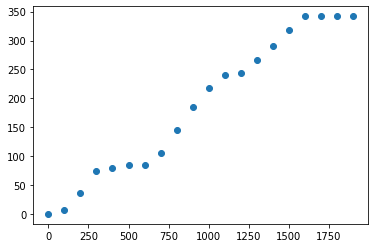

In [132]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.show()

In [137]:
import torch
def map_to_logits (batch, idx): 
  # processors pre-process inputs for multi-modal models such as Wav2Vec2 (speech & text)
  # processors contain tokenizers (for the text modality) & feature extractors (for vision and audio)
  # resample input without changing size
  # processor() in forward direction is assumed processor.feature_extractor(), written for clarity
  inputs = processor.feature_extractor(batch[idx]["file_path"]["array"], sampling_rate=16_000, return_tensors="pt")
  # 'input_values' & 'attention_mask returned' 
  inputs = {k: v.to("cuda") for k,v in inputs.items()}
  with torch.no_grad():
    # model is used to create logits
    logits = model(**inputs).logits
    # processor used for decoding from logits into text
    # processor.batch_decode() in backward direction is assumed processor.tokenizer(), written for clarity
    transcript = processor.batch_decode(logits.cpu().numpy()).text[0]
  return inputs, logits, transcript

# understanding relationship between data point and logit produced

for i, x in enumerate(dataset):
  inputs, logits, transcript = map_to_logits(dataset,i)
  transcription = processor.batch_decode(logits.cpu().numpy()).text[0]
  print(f"\n ****new datapoint**** \n input: {x['file_path']['array'].shape} \n processor(inputs): → {inputs['input_values'].shape, inputs['attention_mask'].shape} \n model(**inputs).logits:→ {logits.shape} \n processor.batch_decode: → {len(transcript)} \n")



 ****new datapoint**** 
 input: (614080,) 
 processor(inputs): → (torch.Size([1, 614080]), torch.Size([1, 614080])) 
 model(**inputs).logits:→ torch.Size([1, 1918, 32]) 
 processor.batch_decode: → 342 


 ****new datapoint**** 
 input: (941760,) 
 processor(inputs): → (torch.Size([1, 941760]), torch.Size([1, 941760])) 
 model(**inputs).logits:→ torch.Size([1, 2942, 32]) 
 processor.batch_decode: → 486 



RuntimeError: ignored

In [20]:
processor.feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "processor_class": "Wav2Vec2ProcessorWithLM",
  "return_attention_mask": true,
  "sampling_rate": 16000
}

In [23]:
processor.batch_decode()

TypeError: ignored

In [ ]:
datum = torch.from_numpy(dataset[0]['file_path']['array'])
datum = datum.reshape(1,len(datum),1)
datum.size()


torch.Size([1, 614080, 1])

### Download model

In [ ]:
import transformers
from transformers import pipeline

asr = pipeline("automatic-speech-recognition", model="patrickvonplaten/hubert-xlarge-ls960-ft-4-gram", device=0, chunk_length_s=10, stride_length_s=(4, 2))


### Creating iterator for bulk transcription

In [ ]:
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm, trange

# KeyDataset (only *pt*) will simply return the item in the dict returned by the dataset item
# as we're not interested in the *target* part of the dataset
transcripts =  tqdm(asr(KeyDataset(dataset, "file_path")))

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
transcription = next(iter(transcripts))

/root/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py:664: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f397e3df750> was reported to be 3 (when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
/root/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py:664: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f397e3df750> was reported to be 3 (when accessing len(dataloader)), but 5 samples have been fetched. 
  warnings.warn(warn_msg)
/root/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py:664: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7f397e3df750> was reported to be 3 (when accessing len(dataloader)), but 6 samples have been fetched. 
  warnings.warn(warn_msg)
/root/.local/lib/python3.7/site-packages/torch/utils/data/datalo

In [ ]:
transcription['text']

"R E I AM CALLING REGARDING YOUR TRUEST ACCOUNT YOUR BIRTHDAY IS THE FIVE OF JEWEL REPLIED MADISON AH WELL I AM LISTENING I AM CALLING THE GUARDING YOU THROUGH WITH THE COUNT YOU'RE SUPPOSED TO HAVE MADE A PAYMENT OF THOUSAND RAN YOU HAVEN'T RIGHT WHY HAVEN'T YOU PAID RUDIN CHECK ON A SYSTEM I WILL PAY IT ON YESTERDAY OH ALL RIGHT DON'T YOU TAKE IT WE WILL HAVE IT AND I FOR BANK HERE BY A BIT DO YOU KNOW"

In [ ]:
from transformers import Wav2Vec2ProcessorWithLM
sampling_rate = dataset.features["sample_rate"]
processor = Wav2Vec2ProcessorWithLM.from_pretrained("patrickvonplaten/hubert-xlarge-ls960-ft-4-gram")
model = asr.model

In [ ]:
raw_audio = torch.from_numpy(dataset[0]['file_path']['array']).reshape([1, dataset[0]['file_path']['array'].size, 1])
model(torch.from_numpy((raw_audio)))

In [ ]:
# audio file is decoded on the fly
idx = 0
inputs = processor(dataset[idx]["file_path"]["array"], sampling_rate=dataset[idx]['sample_rate'], return_tensors="pt")
inputs['input_values'].shape, inputs['attention_mask'].shape

(torch.Size([1, 614080]), torch.Size([1, 614080]))

In [ ]:
"""
import pandas as pd
import time
data = []
duration = 0
taken = 0
mount = '/content/data/'

start_0 = time.time()
for i, transcript in enumerate(transcripts, start=0):
  start = time.time()
  print(f"--idx {i}")
  print(dataset[i]["duration_seconds"])
  duration += dataset[i]["duration_seconds"]
  data.append({"file":dataset[i]["file_path"].replace(mount,"") ,"ground_truth":dataset[i]["words"], "model": transcript["text"] })
  elapsed = time.time() - start
  print(elapsed)
  taken += elapsed
  dataframe = pd.DataFrame(data)
  if i == 2:
    break
    """
    if i==0: continue
    print("saving csv to blob")
    dataframe.to_csv(f'/content/data/tcrs_base_0to{i}.csv')
    print(duration/taken)
    end_0 = time.time()
    break
"""


--idx 0
300.26
0.0026192665100097656
--idx 1
158.7
0.002262592315673828
--idx 2
350.7
0.0015118122100830078


In [ ]:
dataframe.to_csv('/content/data/tcrs_base_1050to1905.csv')